# Computational Astrophysics
## Elliptic PDEs. Examples

---
## Eduard Larrañaga

Observatorio Astronómico Nacional\
Facultad de Ciencias\
Universidad Nacional de Colombia

---

### About this notebook

In this notebook we present some of the techniques used to solve the Poisson equation.

`A. Garcia. Numerical Methods for Physics. (1999). Chapter 6 - 7 `

---

##  Poisson Equation as an ODE Example. Homogenoeous Sphere

Consider the Poisson equation

\begin{equation}
\nabla^2 \Phi =  4\pi G \rho\,\,
\end{equation}

with spherical symmetry as a second-order ODE  

\begin{equation}
\frac{d^2 \Phi}{d r^2}  + \frac{2}{r}\frac{d \Phi}{d r}  = 4 \pi G\rho\,\,.
\end{equation}

This equation is reduced to the system

\begin{equation}
\begin{aligned}
\frac{d \Phi}{dr} &= z\,\,,\\
\frac{dz}{dr}  + \frac{2}{r} z &= 4 \pi G \rho\,\,.
\end{aligned}
\end{equation}

As a first example, we will consider the simplified case of an homogeneous sphere (constant density) and we will use
the following inner and outer boundary conditions,

\begin{equation}
\begin{aligned}
\left . \frac{d \Phi}{dr} \right| _{r=0} & = 0\,\,,\\
\Phi(R_\mathrm{surface}) &= - \frac{GM}{R_\mathrm{surface}}\,\,.
\end{aligned}
\end{equation}

This system can be integrated using the forward Euler method with an appropriate initial condition at $r=0$.  Since the gravitational potential is determined only up to a constant, the problem can be integrated and later, the solution can be adjusted to match the boundary condition at $R_\mathrm{surface}$.


We will consider a model with a total mass of 1 solar mass and a surface radius equal to the solar radius.

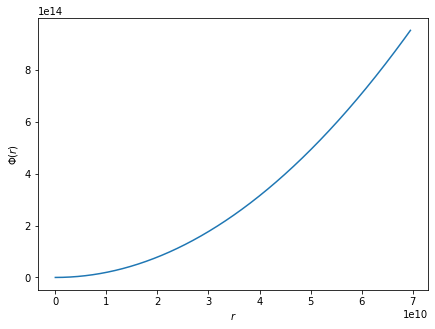

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Uniform sphere model. rho = const. 

M = 1.989e33 # Solar mass in g
R = 6.955e10 # Solar radius in cm
rho = M/((4./3.)*np.pi*R**3) # constant density (gr/cm^3)

# Global constants (cgs units)
G = 6.67e-8

# ODE definition
def ODE(r, q0, rho0):
    '''
    ------------------------------------------
    ODE(r,q0) 
    ------------------------------------------
    ODEs system for the Poisson Equation
    Arguments:
    r: radius
    q0: numpy array with the initial condition
        data:
        q0[0] = Phi
        q0[1] = dPhi/dr
    ------------------------------------------
    '''
    Phi = q0[0]
    z = q0[1]
    f = np.zeros(2)
    f[0] = z
    f[1] = 4*np.pi*G*rho0 - 2*z/r
    return f

def FEuler(h, r0, q0, rho0):
    '''
    ------------------------------------------
    FEuler(h, r0, q0, rho0)
    ------------------------------------------
    Forward Euler's method for solving a ODEs 
    system.
    Arguments:
    h: stepsize for the iteration
    r0: independent parameter initial value
    q0: numpy array with the initial values of
        the functions in the ODEs system
    ------------------------------------------
    '''
    f = ODE(r0, q0, rho0)
    q1 = q0 + h*f
    return q1

# Grid definition
n = 1000 # steps in the grid
r_0 = 1e-8 # Note that we don't begin at r_0=0
r_f = R


# Constant stepsize defined by the number of steps in the grid
h = (r_f - r_0)/n

# Arrays to store the solution
radius = np.linspace(r_0, r_f, n) # Radius information
Q = np.zeros([2,n]) # Euler's Method information


# Initial Conditions
Q[0,0] = 0. # Initial guess for the value of the potential at the center 
Q[1,0] = 0. # Derivative of the potential at the center


# Main loops for solving the problem
for i in range(1,n):
    q0 = Q[:,i-1]
    qf = FEuler(h, radius[i-1], q0, rho)
    Q[:,i] = qf[:]


plt.figure(figsize=(7,5))
plt.plot(radius,Q[0])
plt.xlabel(r'$r$')
plt.ylabel(r'$\Phi(r)$')
plt.show()

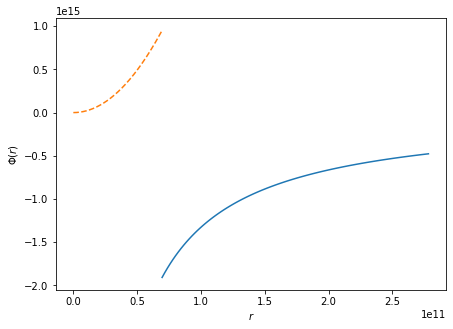

In [7]:
radius_ext = np.linspace(R, 4*R, 100)
plt.figure(figsize=(7,5))
plt.plot(radius_ext,-G*M/radius_ext)
plt.plot(radius,Q[0], '--')
plt.xlabel(r'$r$')
plt.ylabel(r'$\Phi(r)$')
plt.show()

Correcting to match the boundary condition at the surface of the star gives:

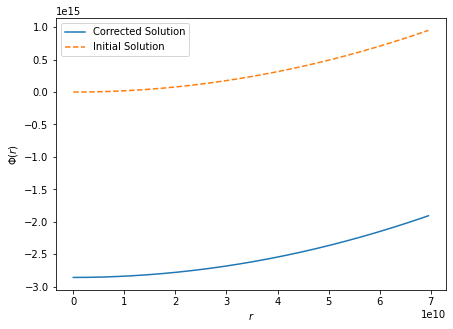

In [6]:
# Adjust of the potential using the boundary condition at R
correction = - G*M/R - Q[0,-1]

Phi_in = Q[0,:] + correction

plt.figure(figsize=(7,5))
plt.plot(radius,Phi_in, label=r'Corrected Solution')
plt.plot(radius,Q[0],'--', label=r'Initial Solution')
plt.xlabel(r'$r$')
plt.ylabel(r'$\Phi(r)$')
plt.legend()
plt.show()

Since $\rho$ is a constant, it is possible to obtain an analytic solution of the Poisson equation, which is given by

\begin{equation}
    \Phi(r) = \frac{2}{3}\pi G \rho  (r^2 - 3 R^2)\,\,.
\end{equation}

A comparison of the numerical and the analytical solution gives

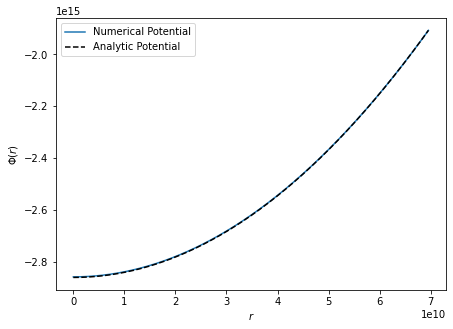

In [9]:
def AnalyticPotential(r):
    return (2*np.pi*G*rho/3)*(r**2 - 3*R**2)


plt.figure(figsize=(7,5))
plt.plot(radius,Phi_in, label=r'Numerical Potential')
plt.plot(radius,AnalyticPotential(radius),'k--', label=r'Analytic Potential')
plt.xlabel(r'$r$')
plt.ylabel(r'$\Phi(r)$')
plt.legend()
plt.show()

Finally, we can include the external Newtonian potential to complete the plot

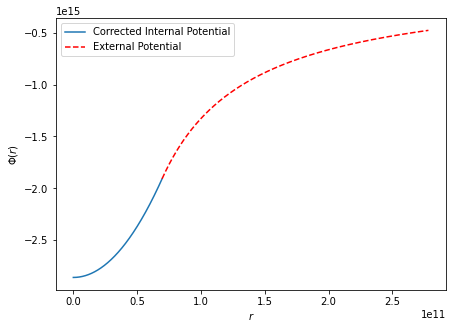

In [8]:
def externalPhi(r):
    return -G*M/r

extradius = np.linspace(R, 4*R, n)
plt.figure(figsize=(7,5))
plt.plot(radius,Phi_in, label=r'Corrected Internal Potential')
plt.plot(extradius,externalPhi(extradius),'r--', label=r'External Potential')
plt.xlabel(r'$r$')
plt.ylabel(r'$\Phi(r)$')
plt.legend()
plt.show()

---

## Poisson Equation solved by the Matrix Method. Homogenoeous Sphere

In the matrix method, the Poisson Equation is discretized with centered differences. Imposing the boundary condition $\frac{\partial \Phi}{ \partial r} = 0$ gives

\begin{equation}
\Phi_{-1} = \Phi_{0}\,\,.
\end{equation}

Then, the Poisson equation is written as linear system

\begin{equation}
J \mathbf{\Phi} = \mathbf{b}\,\,,
\label{eq:pde_poisson2}
\end{equation}

where $\Phi$ = $(\Phi_0, \cdots , \Phi_{n-1})^T$ (for a grid with $n$
points labeled $0$ to $n-1$) and  $\mathbf{b} = 4\pi G
(\rho_0, \cdots , \rho_{n-1})^T$. 


The matrix $J$ has tri-diagonal form and can be explicitely given as

1. $i=j=0$:
\begin{equation}
J_{00} = - \frac{1}{(\Delta r)^2} - \frac{1}{r_0 \Delta r}\,\,,
\end{equation}

2. $i=j$:
\begin{equation}
J_{ij} = \frac{-2}{(\Delta r)^2}\,\,,
\end{equation}

3. $i+1=j$:
\begin{equation}
J_{ij} = \frac{1}{(\Delta r)^2} + \frac{1}{r_i \Delta r}\,\,,
\end{equation}

4. $i-1=j$:
\begin{equation}
J_{ij} = \frac{1}{(\Delta r)^2} - \frac{1}{r_i \Delta r}\,\,.
\end{equation}

Now we solve the homogeneous sphere problem using this description. Once again, we obtain the numerical solution and correct it by adjusting the boundary condition at the surface

\begin{equation}
\Phi(R_\text{surface}) = - \frac{G M}{R_\text{surface}}.
\end{equation}

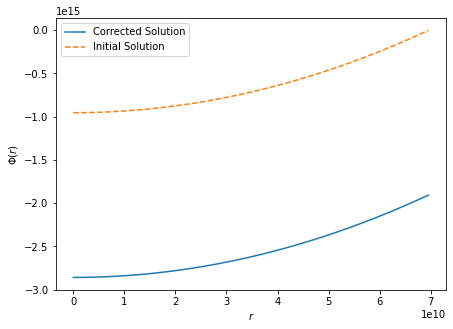

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Uniform sphere model. rho = const. 

M = 1.989e33 # Solar mass in g
R = 6.955e10 # Solar radius in cm
rho = M/((4./3.)*np.pi*R**3) # constant density (gr/cm^3)

# Global constants (cgs units)
G = 6.67e-8

# Grid definition
n = 1000 # steps in the grid
r_0 = 1e-8
r_f = R


# Constant stepsize defined by the number of steps in the grid
dr = (r_f - r_0)/n

# Arrays to store the solution
radius = np.linspace(r_0, r_f, n) # Radius information


b = (4*np.pi*G*rho)*np.ones(n)

J = np.zeros([n,n])

# Definition of the matrix J
J[0,0] = -1/dr**2 - 1/(dr*r_0)

for i in range(1,n):
    J[i,i] = -2/dr**2
    J[i,i-1] = 1/dr**2 - 1/(dr*radius[i])

for i in range(0,n-1):
    J[i,i+1] = 1/dr**2 + 1/(dr*radius[i])



# Forward Elimination
d = np.zeros(n)
w = np.zeros(n)

d[0] = J[0,0]
w[0] = b[0]/d[0]

for i in range(1,n):
    d[i] = J[i,i] - J[i,i-1]*J[i-1,i]/d[i-1]
    w[i] = (b[i] - w[i-1]*J[i,i-1])/d[i]


# Back-Substitution
y = np.zeros(n)

y[-1] = w[-1]
for i in range(n-2,-1,-1):
    y[i] = w[i] - y[i+1]*J[i,i+1]/d[i]

    

# Adjust of the potential using the boundary condition at R
correction = - G*M/R - y[-1]

Phi = y + correction


plt.figure(figsize=(7,5))
plt.plot(radius, Phi, label=r'Corrected Solution')
plt.plot(radius, y, "--", label=r'Initial Solution')
plt.xlabel(r'$r$')
plt.ylabel(r'$\Phi(r)$')
plt.legend()
plt.show()


Comparison with the analytic potential gives

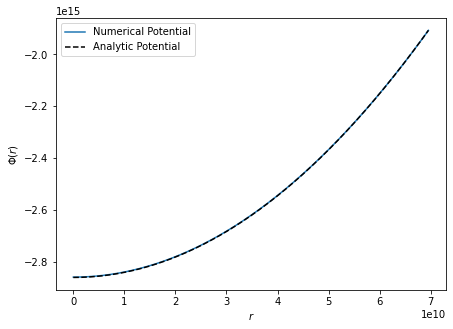

In [11]:
def AnalyticPotential(r):
    return (2*np.pi*G*rho/3)*(r**2 - 3*R**2)


plt.figure(figsize=(7,5))
plt.plot(radius,Phi, label=r'Numerical Potential')
plt.plot(radius,AnalyticPotential(radius),'k--', label=r'Analytic Potential')
plt.xlabel(r'$r$')
plt.ylabel(r'$\Phi(r)$')
plt.legend()
plt.show()

Finally, including the external potential gives the plot

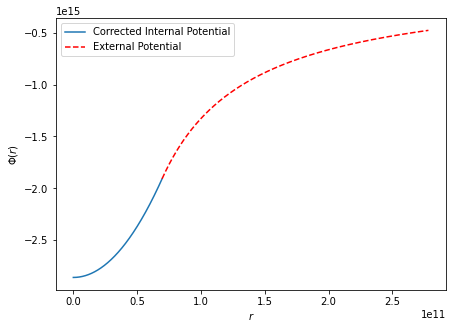

In [12]:
def externalPhi(r):
    return -G*M/r

extradius = np.linspace(R, 4*R, n)
plt.figure(figsize=(7,5))
plt.plot(radius,Phi_in, label=r'Corrected Internal Potential')
plt.plot(extradius,externalPhi(extradius),'r--', label=r'External Potential')
plt.xlabel(r'$r$')
plt.ylabel(r'$\Phi(r)$')
plt.legend()
plt.show()